<a href="https://colab.research.google.com/github/wkabbani/pytorch-playground/blob/main/01_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 01. Workflow

In [1]:
import torch
import torch.nn
import matplotlib.pyplot as plt

torch.__version__

'1.13.0+cu116'

## 01.01. Data

In [2]:
# create some dummy data
weight = 0.7
bias = 0.3

X = torch.arange(start=0, end=1, step=0.02).unsqueeze(dim=1)
y = weight * X + bias

X.ndim, X.shape, y.ndim, y.shape

(2, torch.Size([50, 1]), 2, torch.Size([50, 1]))

In [3]:
X[:5,:], y[:5,:]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800]]), tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560]]))

In [4]:
# split train/test
split = int(0.8 * len(X))

train_X, test_X = X[:split], X[split:]
train_y, test_y = y[:split], y[split:]

len(train_X), len(train_y), len(test_X), len(test_y)

(40, 40, 10, 10)

In [5]:
def plot_data(
    train_data, 
    train_labels, 
    test_data, 
    test_labels, 
    predictions=None
  ):

  plt.figure(figsize=(10,7))

  plt.scatter(train_data, train_labels, c="b", s=4, label="Training Data")

  plt.scatter(test_data, test_labels, c="g", s=4, label="Test Data")

  if predictions is not None:
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  plt.legend(prop={"size": 14})

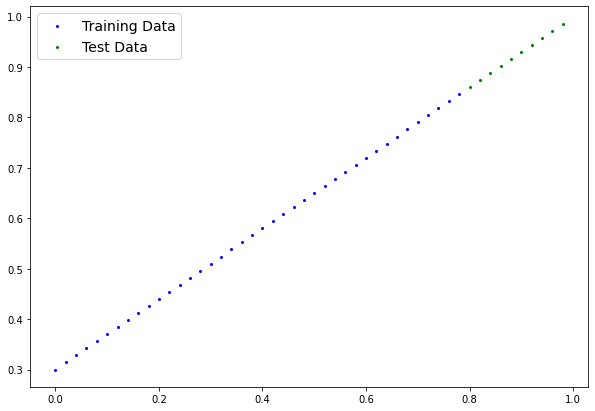

In [6]:
plot_data(train_X, train_y, test_X, test_y)

## 01.02. Model

In [7]:
class LinearRegressionModel(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.weight = torch.nn.Parameter(data=torch.randn(1, dtype=torch.float), requires_grad=True)
    self.bias = torch.nn.Parameter(data=torch.randn(1, dtype=torch.float), requires_grad=True)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.weight * x + self.bias

In [8]:
torch.manual_seed(42)

linear = LinearRegressionModel()

list(linear.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True), Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [9]:
linear.state_dict()

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [10]:
# a newer version of no_grad()
with torch.inference_mode():
  y_preds = linear(test_X)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

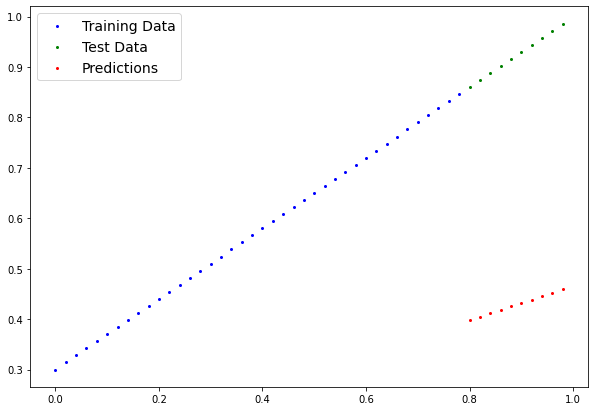

In [11]:
plot_data(train_X, train_y, test_X, test_y, y_preds)

## 01.03. Training

In [12]:
loss_fn = torch.nn.L1Loss()

optimizer = torch.optim.SGD(linear.parameters(), lr=0.01)

In [13]:
# training loop
torch.manual_seed(22)
n_epochs = 100

train_losses = []
test_losses = []
epoch_count = []

for epoch in range(n_epochs):

  # set the model in train mode
  linear.train()

  # forward pass
  y_preds = linear(train_X)

  # calculate loss
  train_loss = loss_fn(y_preds, train_y)

  # reset grads
  optimizer.zero_grad()

  # calculate new grads
  train_loss.backward()

  # update parameters
  optimizer.step()

  # run on the testset
  linear.eval()

  with torch.inference_mode():

    test_preds = linear(test_X)
    test_loss = loss_fn(test_preds, test_y.type(torch.float32))

    if epoch % 10 == 0:
      epoch_count.append(epoch)
      train_losses.append(train_loss.detach().numpy())
      test_losses.append(test_loss.detach().numpy())
      print(f'Epoch: {epoch} - Train Loss: {train_loss:0.2f} - Test Loss: {test_loss:0.2f}')

Epoch: 0 - Train Loss: 0.31 - Test Loss: 0.48
Epoch: 10 - Train Loss: 0.20 - Test Loss: 0.35
Epoch: 20 - Train Loss: 0.09 - Test Loss: 0.22
Epoch: 30 - Train Loss: 0.05 - Test Loss: 0.14
Epoch: 40 - Train Loss: 0.05 - Test Loss: 0.11
Epoch: 50 - Train Loss: 0.04 - Test Loss: 0.10
Epoch: 60 - Train Loss: 0.04 - Test Loss: 0.09
Epoch: 70 - Train Loss: 0.03 - Test Loss: 0.08
Epoch: 80 - Train Loss: 0.03 - Test Loss: 0.07
Epoch: 90 - Train Loss: 0.03 - Test Loss: 0.06


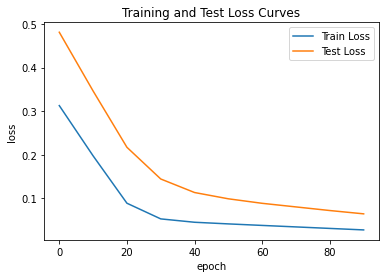

In [14]:
# plot the loss train/test
plt.plot(epoch_count, train_losses, label="Train Loss")
plt.plot(epoch_count, test_losses, label="Test Loss")
plt.title("Training and Test Loss Curves")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

In [15]:
list(linear.parameters())

[Parameter containing:
 tensor([0.5784], requires_grad=True), Parameter containing:
 tensor([0.3513], requires_grad=True)]

In [16]:
linear.state_dict()

OrderedDict([('weight', tensor([0.5784])), ('bias', tensor([0.3513]))])

In [19]:
linear.eval()
with torch.inference_mode():
  y_preds = linear(test_X)

y_preds

tensor([[0.8141],
        [0.8256],
        [0.8372],
        [0.8488],
        [0.8603],
        [0.8719],
        [0.8835],
        [0.8950],
        [0.9066],
        [0.9182]])

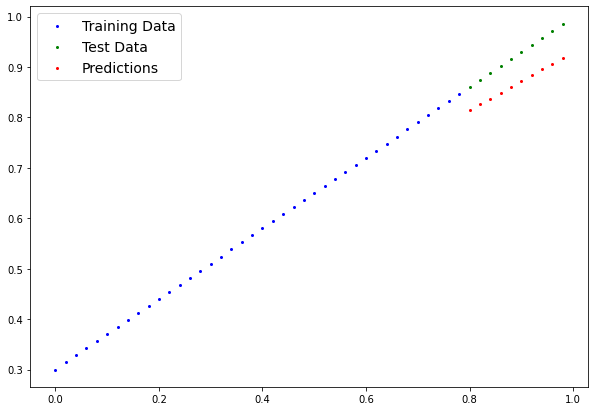

In [20]:
plot_data(train_X, train_y, test_X, test_y, y_preds)

## 01.04. Saving and Loading

In [38]:
from pathlib import Path
model_sd_path = Path('linear_sd_v1.pth')
model_sd_path

PosixPath('linear_sd_v1.pth')

In [39]:
# save model's state dictionary
torch.save(linear.state_dict(), f=model_sd_path)

Why call `torch.load()` inside `torch.nn.Module.load_state_dict()`?

Because we only saved the model's `state_dict()` which is a dictionary of learned parameters and not the entire model, we first have to load the `state_dict()` with `torch.load()` and then pass that `state_dict()` to a new instance of our model (which is a subclass of nn.Module).

In [42]:
loaded_linear_v1 = LinearRegressionModel()
loaded_linear_v1.load_state_dict(torch.load(model_sd_path))

<All keys matched successfully>

In [43]:
loaded_linear_v1.eval()

with torch.inference_mode():
  y_preds = loaded_linear_v1(test_X)

y_preds

tensor([[0.8141],
        [0.8256],
        [0.8372],
        [0.8488],
        [0.8603],
        [0.8719],
        [0.8835],
        [0.8950],
        [0.9066],
        [0.9182]])

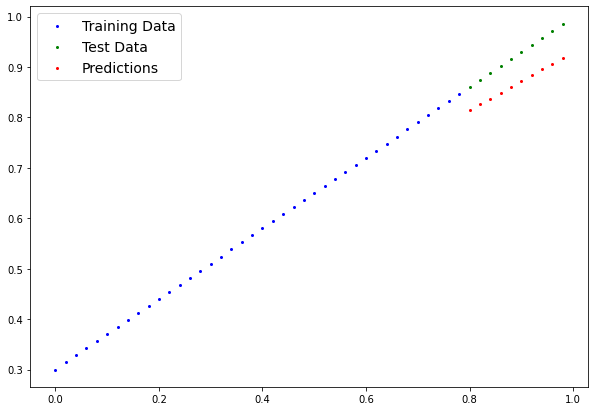

In [44]:
plot_data(train_X, train_y, test_X, test_y, y_preds)